## Predictive Customer Analysis - 3

Following the descriptive analysis of the customer purchase on `Positioning_descriptive.ipynb` notebook, here logistic regression and linear regression will be applied will be performed to deepdive into purchase analysis and forecast.

This notebook continues the content of `Positioning_preditive_2.ipynb`, as it gets longer.

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

import os 
import pickle

## Import the Data

In [2]:
def import_pickle_data(filename) :
    path = os.path.join(os.getcwd(), 'obj_data', filename)
    return pickle.load(open(path, 'rb')) #rb = read as byte datatype

def import_csv(filePath) :
    return pd.read_csv(filePath)

In [3]:
# loading the data file
filePath_purchase = os.path.join(os.getcwd(), 'data', 'purchase data.csv')
df_purchase = import_csv(filePath_purchase)

# importing classes
scaler = import_pickle_data('scaler.pickle')
pca = import_pickle_data('pca.pickle')
kmeans_pca = import_pickle_data('kmeans_pca.pickle')

# standardization
df_purchase.columns.values[-7:] # the 7 features standized 
features_to_include = df_purchase.columns.values[-7:]
df_purchase_std = scaler.transform(df_purchase[features_to_include])

# dimentionality reduction of the standardized data
df_purchase_pca = pca.transform(df_purchase_std)

# segmentation from the preprocessed data
segment_kmeans_pca = kmeans_pca.predict(df_purchase_pca)
df_purchase_analysis = df_purchase.copy()
df_purchase_analysis['Segment'] = segment_kmeans_pca

# binary encoding segment
segment_dummies = pd.get_dummies(df_purchase_analysis['Segment'], 
                                 prefix='Segment', prefix_sep='_')
df_purchase_analysis = pd.concat([df_purchase_analysis, segment_dummies], axis=1)

In [4]:
# Differentiate the dataframe for convenience
df_pa = df_purchase_analysis.copy()

In [5]:
df_pa.head(3)

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,47,1,110866,1,0,0,1,0,0,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,47,1,110866,1,0,0,1,0,0,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,47,1,110866,1,0,0,1,0,0,0


In [6]:
df_pa.columns

Index(['ID', 'Day', 'Incidence', 'Brand', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3', 'Promotion_4',
       'Promotion_5', 'Sex', 'Marital status', 'Age', 'Education', 'Income',
       'Occupation', 'Settlement size', 'Segment', 'Segment_0', 'Segment_1',
       'Segment_2', 'Segment_3'],
      dtype='object')

## `5.` Purchase quantity

In the study of purchase quantity, the linear regression model will also be fit to predict purchase `quantity` (discrete, this time as opposed to probability). 

Firstly, the relevant features will be sorted and assigned as the target variable(s) X, whereas the the qunaity of purchase represented in `Quantity` column will be the target variable Y.

The data only considers when `Incidence` == 1 (purchased only).

### Preparing the data

In [7]:
purchased_only = df_pa.query('Incidence==1').copy()

`Price_` and `Promotion_` columns look related features to purchase quantity. `Last_Inc_Quantity` may be a good candidate for the predict variable but it is represented as binary data so further processing is required (I will skip this for now). They need to be considered in relation to `Brand` feature. For example, only one of the prices is relevent for use when a specific Brand is purchased. Promotion data also must be linked to `Brand` feature. 

For a better, easier calculation for the predictor variables, `Brand` feature will be encoded to generate 5 binary features.

In [8]:
purchase_qty = pd.get_dummies(purchased_only, columns=['Brand'], 
                              prefix='Brand', prefix_sep='_')

Feature engineering to create the predictor variables for price and promotion.

In [9]:
price = (purchase_qty['Price_1'] * purchase_qty['Brand_1'] + 
         purchase_qty['Price_2'] * purchase_qty['Brand_2'] + 
         purchase_qty['Price_3'] * purchase_qty['Brand_3'] + 
         purchase_qty['Price_4'] * purchase_qty['Brand_4'] + 
         purchase_qty['Price_5'] * purchase_qty['Brand_5'] )

In [10]:
promotion = (purchase_qty['Promotion_1'] * purchase_qty['Brand_1'] + 
             purchase_qty['Promotion_2'] * purchase_qty['Brand_2'] + 
             purchase_qty['Promotion_3'] * purchase_qty['Brand_3'] + 
             purchase_qty['Promotion_4'] * purchase_qty['Brand_4'] + 
             purchase_qty['Promotion_5'] * purchase_qty['Brand_5'] )

In [11]:
# Create predictor and target variables
X = pd.concat([price, promotion], axis=1).rename(columns={0:'Price', 1:'Promotion'})
Y = purchase_qty['Quantity']

---
### Fitting a model

In [12]:
lin_reg = LinearRegression(normalize=True)

In [13]:
lin_reg.fit(X, Y)

LinearRegression(normalize=True)

In [14]:
lin_reg.coef_

array([-0.8173651 , -0.10504673])

For every unit price increase will lead to -0.81 less purchase. However it does not easily make sense that customers are expected to buy a bit less when there is promotion. There are some assumptions to explain this. 

1. It is true. Promotion walks customers away to other brands (not effective). But in the earlier price elasicity by segment test, price elasticity is found lower with promotion as opposed to without promotion, so it is conflicting.

2. Again this model is fit to explain average customers, without a consideration by segment.

3. Only two features are considered here which leads to possibility that many important information are missing.

---
### Price elasticity of purchase quantity
Depsite the findings that the model may not be perfect, I assume that everything is alright, and continue the process of calculating the price elasticity of purchase quanity. Formula for elasticity is revisited as below.

<center>Elasticity = $\frac{\Delta Quantity / Quantity}{\Delta Price / Price}$</center>

The formula can be rearranged as $\Delta Quantity / \Delta Price$ equals `beta coefficient.`

<center>Elasticity = $beta * \frac{Price}{Quantity}$</center>

In [15]:
beta = lin_reg.coef_[0]

### `Case 1` When there is promotion

In [16]:
price_range = np.arange(0.5, 3.5, 0.01)
pred_promo_1 = pd.DataFrame(data=price_range, columns=['Price'])
pred_promo_1['Promotion'] = 1 

In [17]:
quantity_promo_1 = lin_reg.predict(pred_promo_1)

In [18]:
PE_promo_1 = beta * price_range / quantity_promo_1

In [19]:
PE_promo_1.shape

(300,)

### `Case 2` When there is _NO_ promotion

In [20]:
price_range = np.arange(0.5, 3.5, 0.01)
pred_promo_0 = pd.DataFrame(data=price_range, columns=['Price'])
pred_promo_0['Promotion'] = 0

In [21]:
quantity_promo_0 = lin_reg.predict(pred_promo_0)
PE_promo_0 = beta * price_range / quantity_promo_0

In [22]:
PE_promo_0.shape

(300,)

---

In [23]:
PE_purchase_qty = pd.DataFrame(data=[PE_promo_1, PE_promo_0]).T

In [24]:
PE_purchase_qty.rename(inplace=True, 
                       columns={0:'With_promo', 1:'Without_promo'})

In [25]:
PE_purchase_qty.insert(loc=0, column='Price', value=price_range)

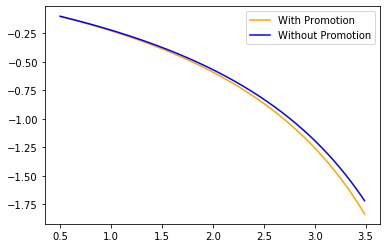

In [26]:
plt.figure(figsize=(6,4))

plt.plot(price_range, PE_promo_1, c='orange', label='With Promotion')
plt.plot(price_range, PE_promo_0, c='blue', label='Without Promotion')

plt.legend()
plt.show()

In [38]:
# pd.options.display.max_rows = None
PE_purchase_qty.iloc[218:228]

,Price,With_promo,Without_promo
218,2.68,-0.987313,-0.942681
219,2.69,-0.994662,-0.949538
220,2.70,-1.002064,-0.956444
221,2.71,-1.009523,-0.963399
222,2.72,-1.017036,-0.970404
223,2.73,-1.024607,-0.977459
224,2.74,-1.032234,-0.984565
225,2.75,-1.039919,-0.991721
226,2.76,-1.047662,-0.998930
227,2.77,-1.055464,-1.006191


In [34]:
df_pa.iloc[:,df_pa.columns.str.contains('Price_')].max()

Price_1    1.59
Price_2    1.90
Price_3    2.14
Price_4    2.26
Price_5    2.80
dtype: float64

### Finding
From the dataset, we can understand that the actual price ranges between 1.59 and 2.80. Price elasticity, however, stays inelastic upto the price of 2.70 (with promotion) and 2.77 (without promotion) and both with/without scenarios does not show a massive  difference in elasticity either. 

When assuming the decent model, the result tells that both price and promotion do not greatly influence price elasticity. 

In the meantime, earlier said, the model lacks features and do not make predictions by segment, which both are worth further studying.